In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten, Dropout, BatchNormalization

In [3]:
df = pd.read_csv(r'./data/data.csv', index_col = 0)
df.head()

,images,label
0,data\benign\SOB_B_TA-14-19854C-100-014.png,0
1,data\malignant\SOB_M_LC-14-16196-40-009.png,1
2,data\malignant\SOB_M_PC-14-15704-200-013.png,1
3,data\malignant\SOB_M_DC-14-9461-200-033.png,1
4,data\benign\SOB_B_TA-14-3411F-100-012.png,0


In [4]:
df['label'] = df['label'].astype('string')

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale = 1./255,  
    rotation_range = 35, 
    shear_range = 0.25,
    zoom_range = 0.25,
    horizontal_flip = True,
    fill_mode = 'nearest')

test_generator = ImageDataGenerator(rescale = 1./255)

train_ds = train_generator.flow_from_dataframe(
    train, 
    x_col='images', 
    y_col='label', 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary'
)

test_ds = test_generator.flow_from_dataframe(
    test, 
    x_col='images', 
    y_col='label', 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary'
)

Found 5448 validated image filenames belonging to 2 classes.
Found 2335 validated image filenames belonging to 2 classes.


## VGG16

In [110]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(150, 150, 3)
)

In [111]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_8 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [112]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [113]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 8192)              0         
                                                                 
 dense_35 (Dense)            (None, 256)               2097408   
                                                                 
 dropout_16 (Dropout)        (None, 256)               0         
                                                                 
 dense_36 (Dense)            (None, 128)               32896     
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_37 (Dense)            (None, 64)               

In [114]:
# run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [115]:
history = model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
171/171 [==============================] - 108s 627ms/step - loss: 0.5837 - accuracy: 0.6913 - val_loss: 0.4351 - val_accuracy: 0.8077
Epoch 2/20
171/171 [==============================] - 98s 571ms/step - loss: 0.4414 - accuracy: 0.8098 - val_loss: 0.3932 - val_accuracy: 0.8244
Epoch 3/20
171/171 [==============================] - 98s 573ms/step - loss: 0.4358 - accuracy: 0.8183 - val_loss: 0.3900 - val_accuracy: 0.8497
Epoch 4/20
171/171 [==============================] - 98s 575ms/step - loss: 0.3880 - accuracy: 0.8432 - val_loss: 0.4006 - val_accuracy: 0.8086
Epoch 5/20
171/171 [==============================] - 98s 574ms/step - loss: 0.3434 - accuracy: 0.8587 - val_loss: 0.3083 - val_accuracy: 0.8827
Epoch 6/20
171/171 [==============================] - 99s 579ms/step - loss: 0.3339 - accuracy: 0.8603 - val_loss: 0.2935 - val_accuracy: 0.8831
Epoch 7/20
171/171 [==============================] - 99s 578ms/step - loss: 0.3251 - accuracy: 0.8715 - val_loss: 0.3204 - val_a

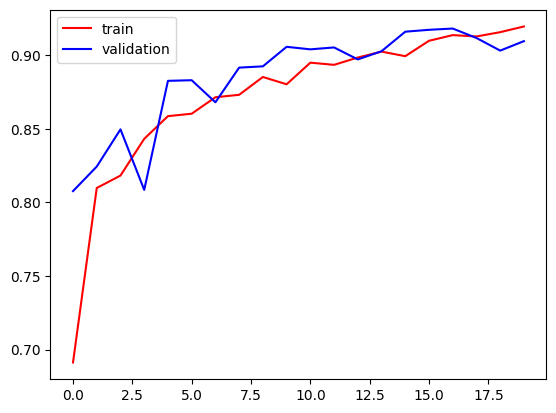

In [116]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

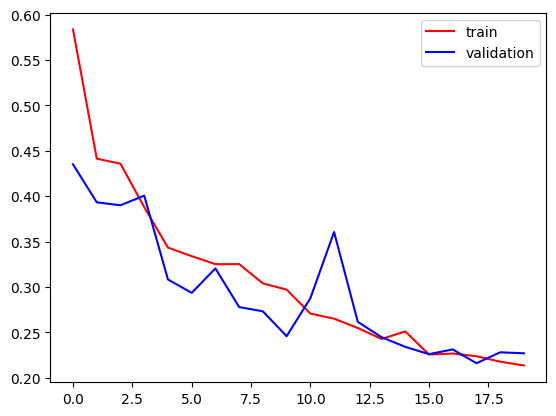

In [117]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [50]:
def Predict(path):
    img = cv2.imread(path)
    img = np.array(img)
    img = cv2.resize(img, (150, 150))
    img = img/255.0
    img = img.reshape((1,150, 150, 3))
    pred = model.predict(img)
    if(pred < 0.7):
        return 0
    else:
        return 1

In [51]:
y_true = test['label'].astype('int').to_numpy()
filenames = test['images'].tolist()

In [120]:
y_predict = [Predict(path) for path in filenames]

1/1 [==============================] - 0s 16ms/step


<Axes: >

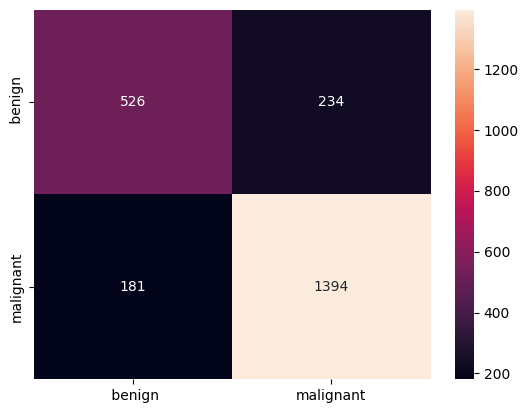

In [121]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_predict)
labels = [" benign", "malignant"]

sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

In [122]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.69      0.72       760
           1       0.86      0.89      0.87      1575

    accuracy                           0.82      2335
   macro avg       0.80      0.79      0.79      2335
weighted avg       0.82      0.82      0.82      2335



In [126]:
model.save("./model/finalModel1/vgg16model.h5")

In [127]:
from keras.models import load_model
model = load_model(r"./model/finalModel1/vgg16model.h5")

## InceptionV3

In [52]:
conv_base = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top = False,
    input_shape=(150, 150, 3)
)

In [53]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'conv2d_80':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
      
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_5 False
conv2d_102 False
batch_normalization_102 False
activation_94 False
conv2d_103 False
batch_normalization_103 False
activation_95 False
conv2d_104 False
batch_normalization_104 False
activation_96 False
max_pooling2d_4 False
conv2d_105 False
batch_normalization_105 False
activation_97 False
conv2d_106 False
batch_normalization_106 False
activation_98 False
max_pooling2d_5 False
conv2d_110 False
batch_normalization_110 False
activation_102 False
conv2d_108 False
conv2d_111 False
batch_normalization_108 False
batch_normalization_111 False
activation_100 False
activation_103 False
average_pooling2d_9 False
conv2d_107 False
conv2d_109 False
conv2d_112 False
conv2d_113 False
batch_normalization_107 False
batch_normalization_109 False
batch_normalization_112 False
batch_normalization_113 False
activation_99 False
activation_101 False
activation_104 False
activation_105 False
mixed0 False
conv2d_117 False
batch_normalization_117 False
activation_109 False
conv2d_115 False
conv2d_1

In [54]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))

model.add(Dense(64,activation='relu'))

model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [55]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 18432)             0         
                                                                 
 dense_15 (Dense)            (None, 256)               4718848   
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 32)                2080      
                                                                 
 dense_19 (Dense)            (None, 1)                

In [56]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [57]:
history = model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
171/171 [==============================] - 106s 595ms/step - loss: 0.6087 - accuracy: 0.7329 - val_loss: 0.4715 - val_accuracy: 0.7863
Epoch 2/20
171/171 [==============================] - 105s 613ms/step - loss: 0.4767 - accuracy: 0.7818 - val_loss: 0.4612 - val_accuracy: 0.7957
Epoch 3/20
171/171 [==============================] - 102s 597ms/step - loss: 0.4593 - accuracy: 0.7924 - val_loss: 0.5464 - val_accuracy: 0.7448
Epoch 4/20
171/171 [==============================] - 103s 602ms/step - loss: 0.4611 - accuracy: 0.7851 - val_loss: 0.4307 - val_accuracy: 0.8060
Epoch 5/20
171/171 [==============================] - 101s 591ms/step - loss: 0.4272 - accuracy: 0.8142 - val_loss: 0.4294 - val_accuracy: 0.8004
Epoch 6/20
171/171 [==============================] - 102s 594ms/step - loss: 0.4191 - accuracy: 0.8075 - val_loss: 0.4354 - val_accuracy: 0.7953
Epoch 7/20
171/171 [==============================] - 101s 593ms/step - loss: 0.3995 - accuracy: 0.8164 - val_loss: 0.4674 -

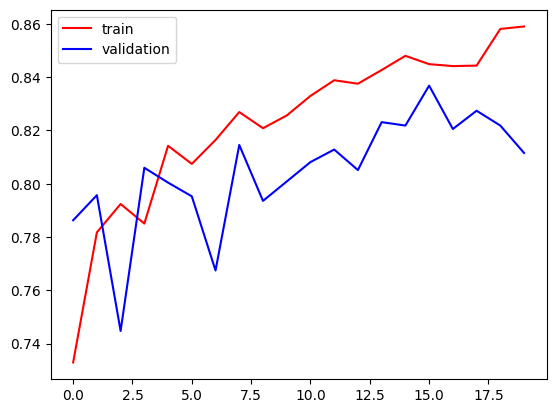

In [58]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

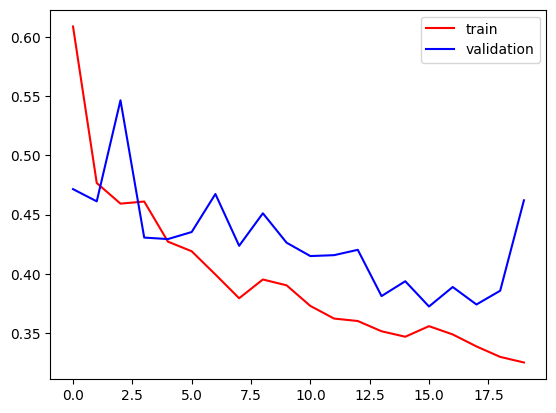

In [59]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [60]:
y_predict = [Predict(path) for path in filenames]

1/1 [==============================] - 0s 41ms/step


<Axes: >

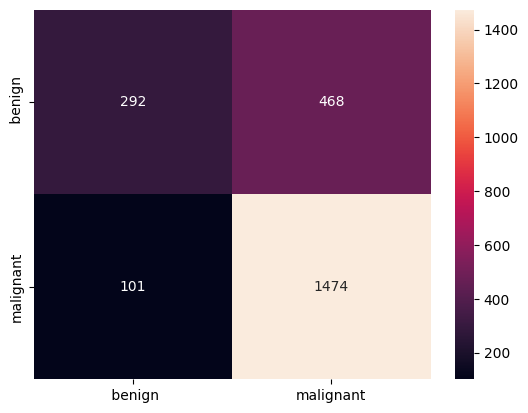

In [61]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_predict)
labels = [" benign", "malignant"]

sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

In [62]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.38      0.51       760
           1       0.76      0.94      0.84      1575

    accuracy                           0.76      2335
   macro avg       0.75      0.66      0.67      2335
weighted avg       0.75      0.76      0.73      2335



In [63]:
model.save("./model/finalModel2/inception.h5")

## VGG19

In [22]:
conv_base = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
    input_shape=(150, 150, 3)
)

80134624/80134624 [==============================] - 20s 0us/step


In [23]:
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_2 True
block1_conv1 True
block1_conv2 True
block1_pool True
block2_conv1 True
block2_conv2 True
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_conv4 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_conv4 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [24]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
      
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [25]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_5 (Dense)             (None, 256)               2097408   
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                

In [27]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
history = model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
171/171 [==============================] - 105s 591ms/step - loss: 0.5843 - accuracy: 0.7293 - val_loss: 0.8411 - val_accuracy: 0.6745
Epoch 2/20
171/171 [==============================] - 101s 594ms/step - loss: 0.4391 - accuracy: 0.8075 - val_loss: 0.3897 - val_accuracy: 0.8390
Epoch 3/20
171/171 [==============================] - 103s 601ms/step - loss: 0.3703 - accuracy: 0.8504 - val_loss: 0.4927 - val_accuracy: 0.8184
Epoch 4/20
171/171 [==============================] - 100s 588ms/step - loss: 0.3594 - accuracy: 0.8587 - val_loss: 0.3392 - val_accuracy: 0.8531
Epoch 5/20
171/171 [==============================] - 104s 611ms/step - loss: 0.3308 - accuracy: 0.8660 - val_loss: 0.3225 - val_accuracy: 0.8711
Epoch 6/20
171/171 [==============================] - 104s 610ms/step - loss: 0.3144 - accuracy: 0.8756 - val_loss: 0.3052 - val_accuracy: 0.8741
Epoch 7/20
171/171 [==============================] - 108s 631ms/step - loss: 0.2986 - accuracy: 0.8805 - val_loss: 0.2999 -

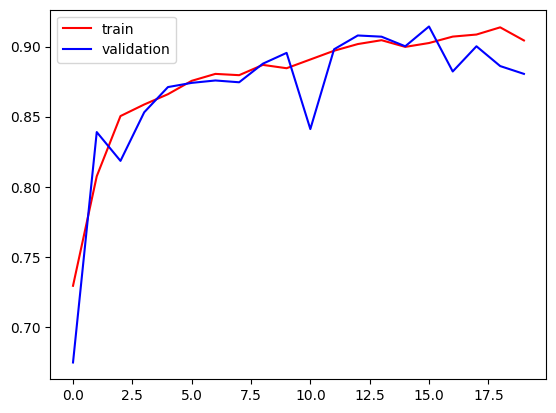

In [29]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

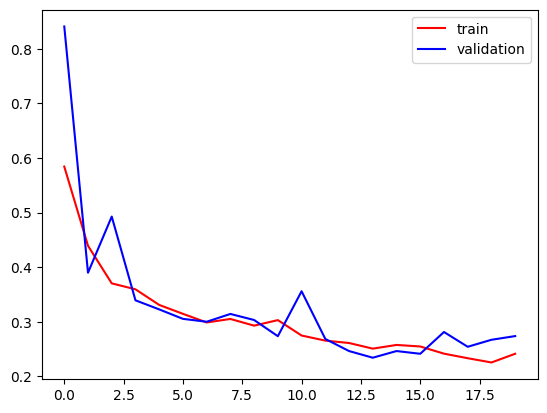

In [30]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [31]:
y_predict = [Predict(path) for path in filenames]

1/1 [==============================] - 0s 31ms/step


<Axes: >

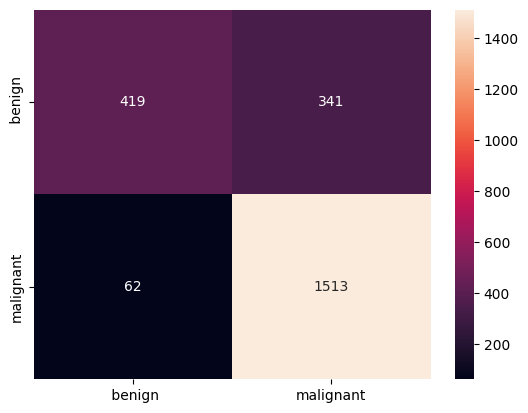

In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_predict)
labels = [" benign", "malignant"]

sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

In [33]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.55      0.68       760
           1       0.82      0.96      0.88      1575

    accuracy                           0.83      2335
   macro avg       0.84      0.76      0.78      2335
weighted avg       0.83      0.83      0.82      2335



In [34]:
model.save("./model/finalModel3/vgg19.h5")

## Xception

In [36]:
conv_base = tf.keras.applications.Xception(
    weights='imagenet',
    include_top = False,
    input_shape=(150, 150, 3)
)

83683744/83683744 [==============================] - 17s 0us/step


In [38]:
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_4 True
block1_conv1 True
block1_conv1_bn True
block1_conv1_act True
block1_conv2 True
block1_conv2_bn True
block1_conv2_act True
block2_sepconv1 True
block2_sepconv1_bn True
block2_sepconv2_act True
block2_sepconv2 True
block2_sepconv2_bn True
conv2d_98 True
block2_pool True
batch_normalization_98 True
add_12 True
block3_sepconv1_act True
block3_sepconv1 True
block3_sepconv1_bn True
block3_sepconv2_act True
block3_sepconv2 True
block3_sepconv2_bn True
conv2d_99 True
block3_pool True
batch_normalization_99 True
add_13 True
block4_sepconv1_act True
block4_sepconv1 True
block4_sepconv1_bn True
block4_sepconv2_act True
block4_sepconv2 True
block4_sepconv2_bn True
conv2d_100 True
block4_pool True
batch_normalization_100 True
add_14 True
block5_sepconv1_act True
block5_sepconv1 True
block5_sepconv1_bn True
block5_sepconv2_act True
block5_sepconv2 True
block5_sepconv2_bn True
block5_sepconv3_act True
block5_sepconv3 True
block5_sepconv3_bn True
add_15 True
block6_sepconv1_act True
block

In [39]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block12_sepconv1_act':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
      
for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_4 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d_98 False
block2_pool False
batch_normalization_98 False
add_12 False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_99 False
block3_pool False
batch_normalization_99 False
add_13 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_100 False
block4_pool False
batch_normalization_100 False
add_14 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act False
block5_sepconv3 False
block5_sepconv3_bn Fal

In [40]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [41]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_10 (Dense)            (None, 256)               13107456  
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 dense_14 (Dense)            (None, 1)                

In [42]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [43]:
history = model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
171/171 [==============================] - 98s 558ms/step - loss: 0.5518 - accuracy: 0.7379 - val_loss: 1.3577 - val_accuracy: 0.7118
Epoch 2/20
171/171 [==============================] - 95s 554ms/step - loss: 0.3888 - accuracy: 0.8388 - val_loss: 0.3724 - val_accuracy: 0.8570
Epoch 3/20
171/171 [==============================] - 95s 557ms/step - loss: 0.3142 - accuracy: 0.8743 - val_loss: 0.6301 - val_accuracy: 0.8124
Epoch 4/20
171/171 [==============================] - 95s 554ms/step - loss: 0.2778 - accuracy: 0.8963 - val_loss: 0.3025 - val_accuracy: 0.8707
Epoch 5/20
171/171 [==============================] - 96s 559ms/step - loss: 0.2460 - accuracy: 0.9057 - val_loss: 0.2913 - val_accuracy: 0.8964
Epoch 6/20
171/171 [==============================] - 95s 554ms/step - loss: 0.2281 - accuracy: 0.9106 - val_loss: 0.3407 - val_accuracy: 0.8728
Epoch 7/20
171/171 [==============================] - 95s 554ms/step - loss: 0.1929 - accuracy: 0.9244 - val_loss: 0.3763 - val_ac

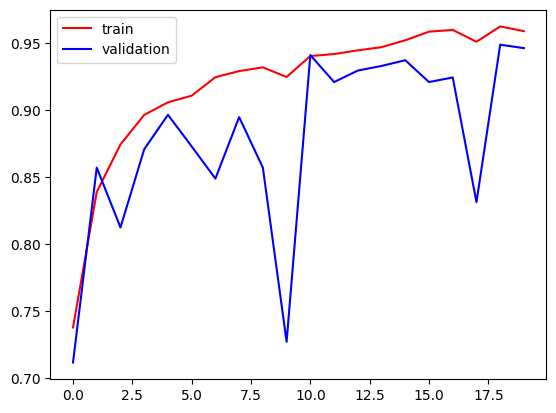

In [44]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

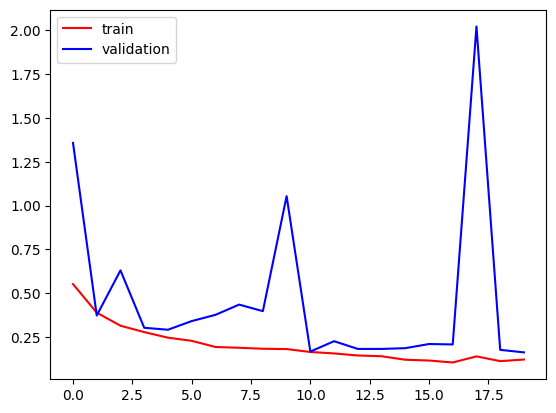

In [45]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [46]:
y_predict = [Predict(path) for path in filenames]

1/1 [==============================] - 0s 28ms/step


<Axes: >

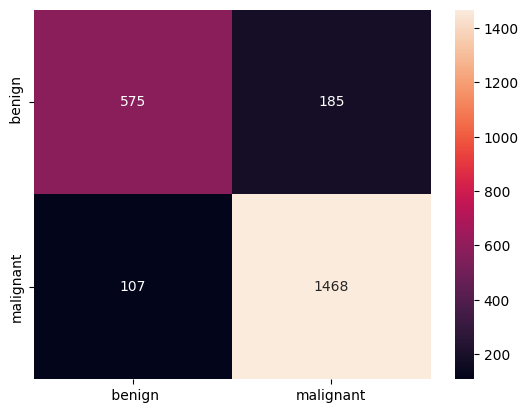

In [47]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_predict)
labels = [" benign", "malignant"]

sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)

In [48]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_predict)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.76      0.80       760
           1       0.89      0.93      0.91      1575

    accuracy                           0.87      2335
   macro avg       0.87      0.84      0.85      2335
weighted avg       0.87      0.87      0.87      2335



In [49]:
model.save("./model/finalModel4/xception.h5")

## Comparison

In [212]:
model_names = ['VGG 16', 'VGG 19', 'InceptionV3' , 'Xception']
epochs = range(1, 21)  

losses_model1 = [0.5837, 0.4414, 0.4358, 0.388, 0.3434, 0.3339, 0.3251, 0.3251, 0.3039, 0.2971, 0.2707, 0.265, 0.2547, 0.2426, 0.251, 0.2255, 0.2266, 0.2237, 0.2176, 0.2134]
losses_model2 = [0.6087, 0.4767, 0.4593, 0.4611, 0.4272, 0.4191, 0.3995, 0.3795, 0.3953, 0.3904, 0.373, 0.3624, 0.3603, 0.3516, 0.347, 0.356, 0.349, 0.3389, 0.33, 0.3253]
losses_model3 = [0.5843, 0.4391, 0.3703, 0.3594, 0.3308, 0.3144, 0.2986, 0.305, 0.2927, 0.3029, 0.2747, 0.2653, 0.2609, 0.2506, 0.2574, 0.2546, 0.2414, 0.2331, 0.2252, 0.2412]
losses_model4 = [0.5518, 0.3888, 0.3142, 0.2778, 0.246, 0.2281, 0.1929, 0.1884, 0.1828, 0.1809, 0.1644, 0.1561, 0.1443, 0.14, 0.1201, 0.1156, 0.1044, 0.1392, 0.112, 0.1213]


accuracies_model1 = [0.6913, 0.8098, 0.8183, 0.8432, 0.8587, 0.8603, 0.8715, 0.8732, 0.8853, 0.8803, 0.895, 0.8935, 0.8985, 0.9025, 0.8994, 0.9099, 0.9137, 0.9128, 0.9157, 0.9196]
accuracies_model2 = [0.7329, 0.7818, 0.7924, 0.7851, 0.8142, 0.8075, 0.8164, 0.8269, 0.8209, 0.8256, 0.833, 0.8388, 0.8376, 0.8427, 0.848, 0.8449, 0.8442, 0.8443, 0.8581, 0.859]
accuracies_model3 = [0.7293, 0.8075, 0.8504, 0.8587, 0.866, 0.8756, 0.8805, 0.8796, 0.8869, 0.8845, 0.8908, 0.897, 0.9018, 0.9046, 0.8998, 0.9025, 0.9071, 0.9086, 0.9137, 0.9044]
accuracies_model4 = [0.7379, 0.8388, 0.8743, 0.8963, 0.9057, 0.9106, 0.9244, 0.929, 0.9317, 0.9246, 0.9402, 0.9416, 0.9444, 0.9468, 0.9519, 0.9583, 0.9596, 0.9508, 0.9622, 0.9587]

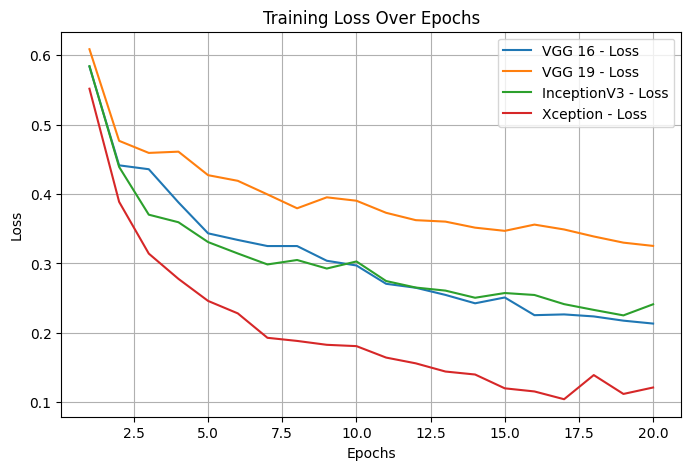

In [213]:
plt.figure(figsize=(8, 5))
for i, model_name in enumerate(model_names):
    plt.plot(epochs, eval(f'losses_model{i + 1}'), label=f'{model_name} - Loss')

plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

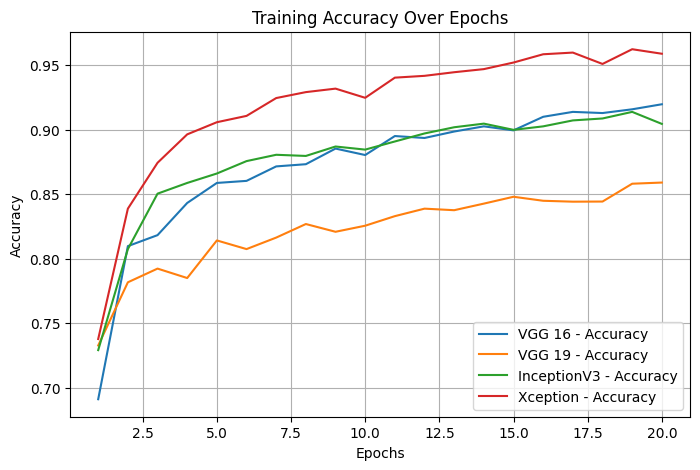

In [214]:
plt.figure(figsize=(8, 5))
for i, model_name in enumerate(model_names):
    plt.plot(epochs, eval(f'accuracies_model{i + 1}'), label=f'{model_name} - Accuracy')

plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Validation

In [83]:
model_names = ['VGG 16', 'VGG 19', 'InceptionV3' , 'Xception']
epochs = range(1, 21)  

losses_model1 =[0.4351, 0.3932, 0.39, 0.4006, 0.3083, 0.2935, 0.3204, 0.2778, 0.2731, 0.2457, 0.2875, 0.3605, 0.2615, 0.2446, 0.234, 0.2259, 0.2311, 0.2159, 0.228, 0.2269]
losses_model2 = [0.8411, 0.3897, 0.4927, 0.3392, 0.3225, 0.3052, 0.2999, 0.3142, 0.3031, 0.2734, 0.3558, 0.2683, 0.2462, 0.234, 0.2462, 0.2412, 0.2811, 0.254, 0.2668, 0.2736]
losses_model3 = [0.4715, 0.4612, 0.5464, 0.4307, 0.4294, 0.4354, 0.4674, 0.4237, 0.4512, 0.4263, 0.4151, 0.4158, 0.4203, 0.3813, 0.3938, 0.3725, 0.389, 0.3742, 0.3858, 0.4621]
losses_model4 = [1.3577, 0.3724, 0.6301, 0.3025, 0.2913, 0.3407, 0.3763, 0.4347, 0.3974, 1.0539, 0.1666, 0.2259, 0.1818, 0.1818, 0.1861, 0.2098, 0.2074, 2.0222, 0.1765, 0.1621]


accuracies_model1 =[0.8077, 0.8244, 0.8497, 0.8086, 0.8827, 0.8831, 0.8681, 0.8916, 0.8925, 0.9058, 0.9041, 0.9054, 0.8972, 0.9028, 0.9161, 0.9173, 0.9182, 0.9118, 0.9032, 0.9096]
accuracies_model2 = [0.6745, 0.839, 0.8184, 0.8531, 0.8711, 0.8741, 0.8758, 0.8745, 0.8878, 0.8955, 0.8411, 0.8981, 0.9079, 0.9071, 0.9002, 0.9143, 0.8822, 0.9002, 0.8861, 0.8805]
accuracies_model3 = [0.7863, 0.7957, 0.7448, 0.806, 0.8004, 0.7953, 0.7675, 0.8146, 0.7936, 0.8009, 0.8081, 0.8128, 0.8051, 0.8231, 0.8218, 0.8368, 0.8206, 0.8274, 0.8218, 0.8116]
accuracies_model4 = [0.7118, 0.857, 0.8124, 0.8707, 0.8964, 0.8728, 0.8488, 0.8946, 0.857, 0.7272, 0.9409, 0.9208, 0.9293, 0.9328, 0.937, 0.9208, 0.9242, 0.8313, 0.9486, 0.946]

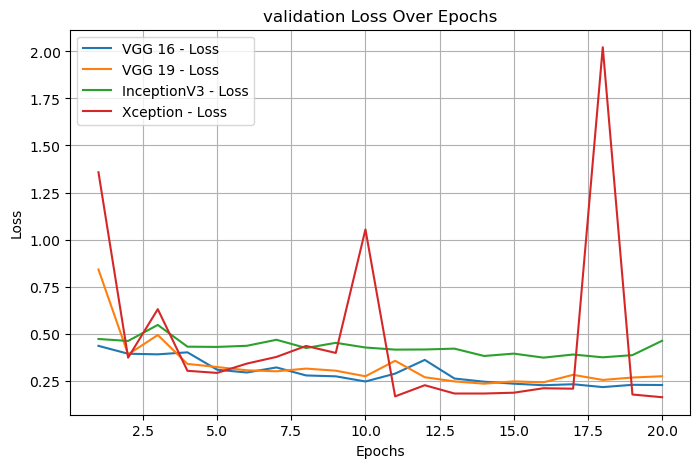

In [84]:
plt.figure(figsize=(8, 5))
for i, model_name in enumerate(model_names):
    plt.plot(epochs, eval(f'losses_model{i + 1}'), label=f'{model_name} - Loss')

plt.title('validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

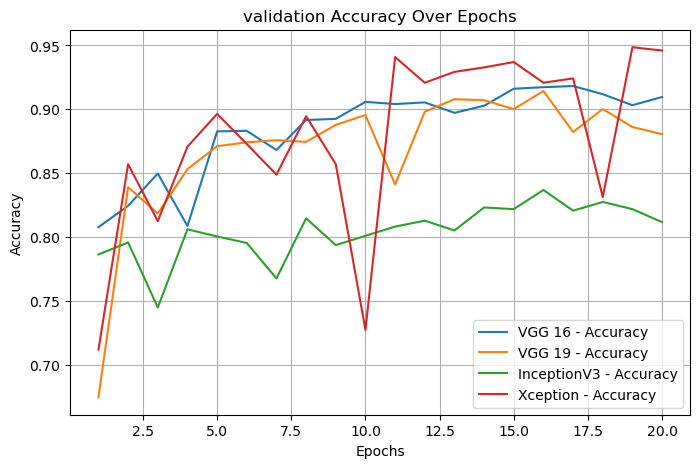

In [85]:
plt.figure(figsize=(8, 5))
for i, model_name in enumerate(model_names):
    plt.plot(epochs, eval(f'accuracies_model{i + 1}'), label=f'{model_name} - Accuracy')

plt.title('validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()